In [30]:
from mcspace.utils import pickle_load
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib.patches as mpatches
import matplotlib as mpl
import numpy as np

from statsmodels.stats.multitest import multipletests
from scipy.stats import mannwhitneyu

In [3]:
# change font
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"

# Paths

In [4]:
basepath = Path("./")
rootpath = Path("../../")

In [5]:
outpath_human = basepath / "main_figures"
outpath_human.mkdir(exist_ok=True, parents=True)

outpath_mouse = basepath / "supplemental_figures"
outpath_mouse.mkdir(exist_ok=True, parents=True)

### paths to results

In [6]:
pwpath = rootpath / "paper" / "results" / "pairwise"
mcpwpath = pwpath / "mcspace_results"
fishpwpath = pwpath / "fisher_results"
ecopwpath = pwpath / "sim9_results"
arrespath = rootpath / "paper" / "results" / "assemblage_recovery"

# Load pairwise results

In [7]:
fishpwres = pd.DataFrame(pickle_load(fishpwpath / "results.pkl"))
mcpwres = pd.DataFrame(pickle_load(mcpwpath / "results.pkl"))
ecopwres = pd.DataFrame(pickle_load(ecopwpath / "results.pkl"))

In [8]:
# combine results
pwres = pd.concat([mcpwres, fishpwres, ecopwres])

# rename column
pwres=pwres.rename(columns={'garbage weight': 'contamination weight'})

# Load assemblage recovery results

In [9]:
arres = pd.DataFrame(pickle_load(arrespath / "results.pkl"))

### add number clusters error

In [10]:
nk_default = 15
nrows, ncols = arres.shape

nk_error = []
for i in range(nrows):
    true_nk = arres.loc[i,'number clusters']
    if true_nk == "default":
        true_nk = nk_default
    model_nk = arres.loc[i,'number clusters learned']
    err = model_nk - true_nk
    nk_error.append(err)

arres['nk_error'] = nk_error

# Render figures

In [24]:
def subset_results(res, subset_var, base_sample):
    temp = res.loc[res[subset_var] != 'default',:]
    temp = temp.loc[temp['base_sample'] == base_sample,:]
    return temp


def make_sub_gs_ax(fig, gs,i,j, ncols, wspace=0.05):
    gssub = gs[i,j].subgridspec(1,ncols,wspace=wspace)
    axs = []
    for k in range(ncols):
        axs.append(fig.add_subplot(gssub[0,k]))
    return gssub, axs

def share_axes(ax, ncol):
    for i in range(ncol-1):
        ax[i].sharey(ax[ncol-1])
    for i in range(1,ncol):
        plt.setp(ax[i].get_yticklabels(), visible=False)
        ax[i].set_ylabel("")
    return ax


def share_axes_r(ax, ncol):
    for i in range(1,ncol):
        ax[i].sharey(ax[0])
        plt.setp(ax[i].get_yticklabels(), visible=False)
        ax[i].set_ylabel("")
    return ax


def compute_corrected_pvalues(data, x, y, model_order, conditions, base='mcspace'):
    n_other = len(model_order) - 1
    n_conditions = len(conditions)
    pvalues = np.zeros((n_other, n_conditions))
    for i,mod in enumerate(model_order[1:]):
        for j, cond in enumerate(conditions):
            base_values = data.loc[(data['model'] == base) & (data[x] == cond),y].values
            comp_values = data.loc[(data['model'] == mod) & (data[x] == cond),y].values
            pval = mannwhitneyu(base_values, comp_values)
            pvalues[i,j] = pval.pvalue
    adjpvals = multipletests(pvalues.reshape((-1,)), alpha=0.05, method='fdr_bh')[1].reshape((n_other, n_conditions))
    return adjpvals


def annotate_pvalues(data, x, value, conditions, adjpvals, ax, h, width, text_h, offset, ns_h_shift):
    n_other, n_cond = adjpvals.shape

    # settings
    data_range = np.amax(data.loc[:,value].values) - np.amin(data.loc[:,value].values)
    
#     h=0.01
#     offset=0.07
#     width = 1.0/n_cond #1.5/n_cond
    STAR_SIZE = 12 #8
    NS_SIZE = 10
    LINEWIDTH = 1.0
    
    for i in range(n_other):
        for j, cond in enumerate(conditions):
            x1 = j - ((n_cond-1)/(2*n_cond)) + width
            x2 = x1 + 2*(i+1)*width #+ 0.01
            max_y = np.quantile(data.loc[data[x] == cond,value].values, q=0.99)
            y = max_y + i*offset + 0.025*data_range

            color = 'black'
            fontsize = STAR_SIZE
            text_h2 = text_h
            pv = adjpvals[i,j]
            if pv < 0.0001:
                levmarker = "****"
            elif pv < 0.001:
                levmarker = "***"
            elif pv < 0.01:
                levmarker = "**"
            elif pv < 0.05:
                levmarker = "*"
            else:
                levmarker = 'ns'
                color='tab:red'
                text_h2 = text_h - ns_h_shift
                fontsize = NS_SIZE
                
            ax.plot([x1, x1, x2, x2], [y+0.5*h, y+1.5*h, y+1.5*h, y+0.5*h], lw=LINEWIDTH, c=color)
            ax.text((x1+x2)*0.5, y+text_h2, levmarker, ha='center', va='bottom', color=color, fontsize=fontsize)
    return ax


def plot_case_results(ax, datasub, x, y, model_order, palette, base_sample):
#     datasub.fillna(1.0, inplace=True)
    ax=sns.boxplot(data=datasub, x=x, y=y, ax=ax, hue='model', 
                   hue_order=model_order, palette=palette, showfliers=False)
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    ax.get_legend().remove()
    return ax


def plot_results(axs, data, cases, y, model_order, palette, base_sample, 
                 h=0.008, width=1.0/5.0, text_h=0.001, offset=0.02, ns_h_shift=0.01, grid=True):
#     cases = ['number particles', 'read depth', 'number clusters', 'contamination weight', 'number subjects']
    for i,case in enumerate(cases):
        datasub = subset_results(data, case, base_sample)
        axs[i]=plot_case_results(axs[i], datasub, case, y, model_order, palette, base_sample)
        conditions = np.sort(datasub[case].unique())
        pvals = compute_corrected_pvalues(datasub, x=case, y=y, model_order=model_order, conditions=conditions)
        axs[i] = annotate_pvalues(datasub, case, y, conditions, pvals, axs[i], h, width, text_h, offset, ns_h_shift)
        
        if grid:
            axs[i].set_axisbelow(True)
            axs[i].yaxis.grid(True, 'major', linewidth=1, color='#e6e6e6')
            axs[i].set_axisbelow(True)
            axs[i].xaxis.grid(True, 'major', linewidth=1, color='#e6e6e6')

    return axs


def box_to_ell_axes(ax):
    # Hide the right and top spines
    ax.spines[['right', 'top']].set_visible(False)
    return ax 


## human data (main figure)

In [19]:
pw_model_order = ['mcspace', 'fisher', 'SIM9']
# pw_palette = ['tab:blue', 'tab:orange', 'tab:green']
pw_palette = [sns.color_palette("Paired")[i] for i in [0,2,3]]
ar_model_order = ['mcspace', 'gmm_basic']
# ar_palette = ['tab:blue', 'tab:red']
ar_palette = [sns.color_palette("Paired")[i] for i in [0,6]]

label_x = -0.35
label_y = 1.0

grid=False

In [20]:
base_sample = 'Human'
cases = ['number particles', 'read depth', 'number clusters', 'contamination weight']

C:\Users\Gary\AppData\Local\Temp\ipykernel_107976\3173949321.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axnmi[0].set_yticklabels(axnmi[0].get_yticklabels(), fontsize=ticklabel_fontsize)
C:\Users\Gary\AppData\Local\Temp\ipykernel_107976\3173949321.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=ticklabel_fontsize, rotation=rotation)
C:\Users\Gary\AppData\Local\Temp\ipykernel_107976\3173949321.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=ticklabel_fontsize, rotation=rotation)
C:\Users\Gary\AppData\Local\Temp\ipykernel_107976\3173949321.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks

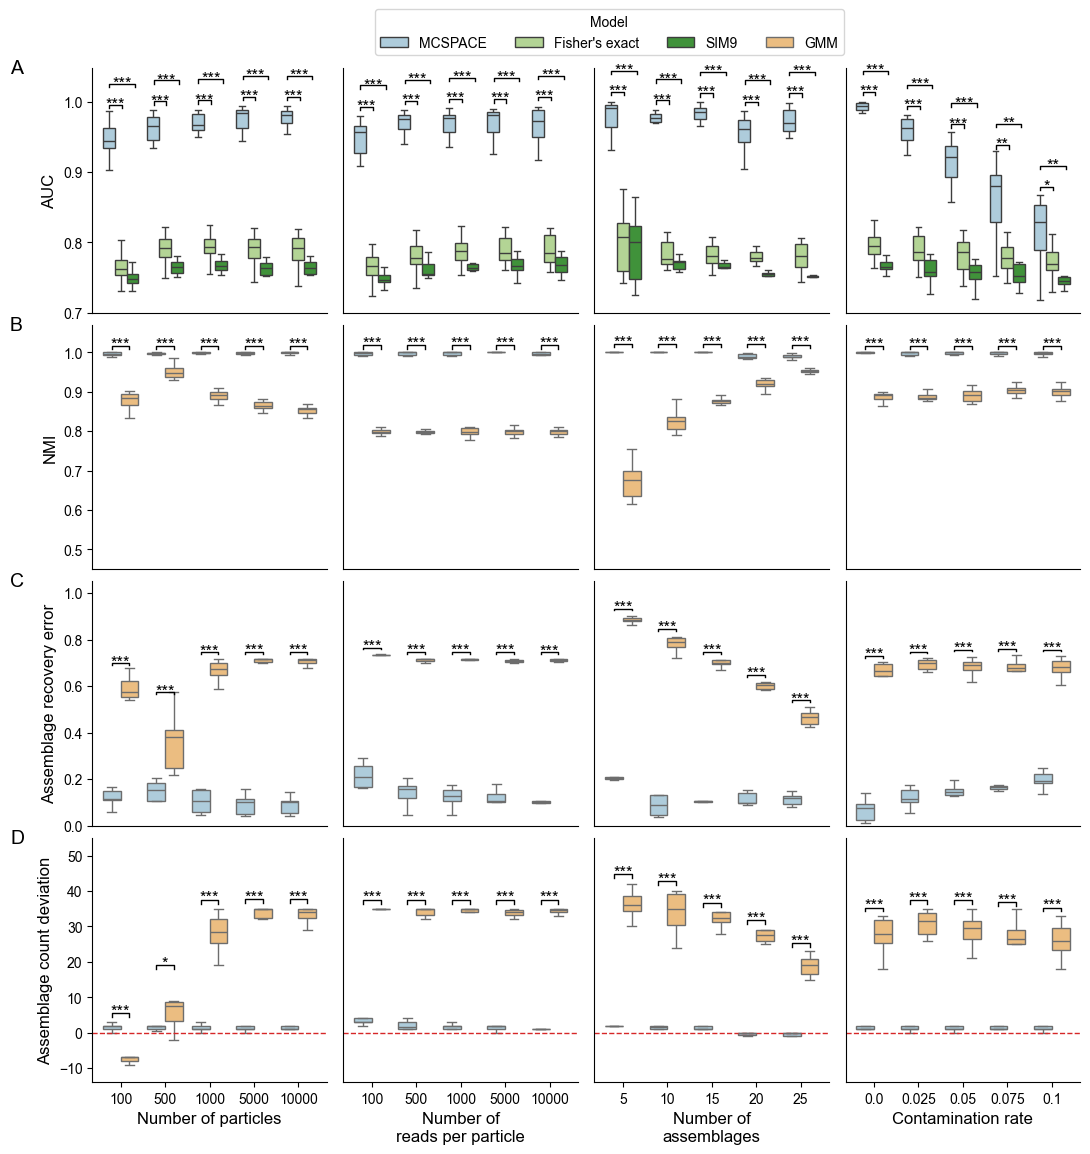

In [26]:
fontsize=12
label_fontsize=14
ticklabel_fontsize=10
rotation=0

scale = 1.5
fig = plt.figure(figsize=(scale*8.5,scale*11))
gs = fig.add_gridspec(ncols=1,nrows=5, hspace=0.05)

wspace = 0.07
ncols = len(cases)
gspw, axpw = make_sub_gs_ax(fig,gs,0,0,ncols,wspace)
gsnmi, axnmi = make_sub_gs_ax(fig,gs,1,0,ncols,wspace)
gsnk, axnk = make_sub_gs_ax(fig,gs,3,0,ncols,wspace)
gsar, axar = make_sub_gs_ax(fig,gs,2,0,ncols,wspace)

# plot pairwise results ======================================
axpw = plot_results(axpw, pwres, cases, 'auc', pw_model_order, pw_palette, base_sample, 
                    width=1.0/7.0, text_h=-0.003, h=0.005, offset=0.03, ns_h_shift=-0.01, grid=grid)
axpw = share_axes(axpw,ncols)
for idx,ax in enumerate(axpw):
    ax.set_xlabel("")
    ax.set_xticklabels("") #ax.get_xticklabels(), fontsize=ticklabel_fontsize, rotation=rotation)

    ax.tick_params('x', length=0, width=0, which='major')
    if idx != 0:
        ax.tick_params('both', length=0, width=0, which='major')

    ax.set_ylim(0.70,1.048)
    ax.set_yticks(np.arange(0.70,1.001,0.1))
    ax=box_to_ell_axes(ax)
axpw[0].set_ylabel("AUC", fontsize=fontsize)
axpw[0].set_yticklabels(axpw[0].get_yticklabels(), fontsize=ticklabel_fontsize)
# for i in range(1,len(axpw)):
#     axpw[i].set_yticklabels("")
# axpw[0].set_yticklabels(np.arange(0.70,1.001,0.05), fontsize=fontsize)
axpw[0].text(label_x, label_y, 'A', horizontalalignment='left',verticalalignment='center', transform=axpw[0].transAxes, fontsize=label_fontsize)

# plot NMI results ======================================
axnmi = plot_results(axnmi, arres, cases, 'NMI', ar_model_order, ar_palette, base_sample, text_h=-0.003, grid=grid)
axnmi = share_axes(axnmi,ncols)
for idx,ax in enumerate(axnmi):
    ax.set_xlabel("")
    ax.set_xticklabels("") #ax.get_xticklabels(), fontsize=ticklabel_fontsize, rotation=rotation)

    ax.tick_params('x', length=0, width=0, which='major')
    if idx != 0:
        ax.tick_params('both', length=0, width=0, which='major')
    ax.set_ylim(0.45,1.07)
    ax=box_to_ell_axes(ax)
axnmi[0].set_ylabel("NMI", fontsize=fontsize)
axnmi[0].set_yticklabels(axnmi[0].get_yticklabels(), fontsize=ticklabel_fontsize)
axnmi[0].text(label_x, label_y, 'B', horizontalalignment='left',verticalalignment='center', transform=axnmi[0].transAxes, fontsize=label_fontsize)

# plot nk err results ======================================
axnk = plot_results(axnk, arres, cases, 'nk_error', ar_model_order, ar_palette, base_sample, h=1.1, text_h=0, grid=grid)
for idx,ax in enumerate(axnk):
    ax.axhline(y=0, color='tab:red', linestyle='--', linewidth=1)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=ticklabel_fontsize, rotation=rotation)

#     ax.tick_params('x', length=0, width=0, which='major')
    if idx != 0:
        ax.tick_params('y', length=0, width=0, which='major')
    ax.set_ylim(-14,55)
    ax=box_to_ell_axes(ax)
axnk = share_axes_r(axnk,ncols)
# axnk[0].set_ylabel("Number of inferred\nassemblages minus\ntrue number", fontsize=fontsize)
axnk[0].set_ylabel("Assemblage count deviation", fontsize=fontsize)
axnk[0].set_yticklabels(axnk[0].get_yticklabels(), fontsize=ticklabel_fontsize)
axnk[0].text(label_x, label_y, 'D', horizontalalignment='left',verticalalignment='center', transform=axnk[0].transAxes, fontsize=label_fontsize)
axnk[0].set_xlabel("Number of particles", fontsize=fontsize)
axnk[1].set_xlabel("Number of\nreads per particle", fontsize=fontsize)
axnk[2].set_xlabel("Number of\nassemblages", fontsize=fontsize)
axnk[3].set_xlabel("Contamination rate", fontsize=fontsize)
# axar[4].set_xlabel("Number of subjects", fontsize=fontsize)


# plot comm err results ======================================
axar = plot_results(axar, arres, cases, 'community error', ar_model_order, ar_palette, base_sample, text_h=-0.015, grid=grid)
axar = share_axes(axar,ncols)

for idx,ax in enumerate(axar):
    ax.set_xlabel("")
    ax.set_xticklabels("") #ax.get_xticklabels(), fontsize=ticklabel_fontsize, rotation=rotation)

    ax.tick_params('x', length=0, width=0, which='major')
    if idx != 0:
        ax.tick_params('y', length=0, width=0, which='major')
    ax.set_ylim(0,1.05)
    ax=box_to_ell_axes(ax)
axar[0].set_yticklabels(axar[0].get_yticklabels(), fontsize=ticklabel_fontsize)
axar[0].text(label_x, label_y, 'C', horizontalalignment='left',verticalalignment='center', transform=axar[0].transAxes, fontsize=label_fontsize)
axar[0].set_ylabel("Assemblage recovery error", fontsize=fontsize)

# legend ===================================================
lines_labels = [axpw[0].get_legend_handles_labels(), axnmi[0].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
mod_sub = [0,1,2,4]
# mod_sub = [0,1,3]
lines = [lines[i] for i in mod_sub]
labels = [labels[i] for i in mod_sub]

labels = ['MCSPACE', "Fisher's exact", 'SIM9', 'GMM']
# labels = ['MCSPACE', "Fisher's exact", 'Basic GMM']
fig.legend(lines, labels, title='Model', loc='upper right', bbox_to_anchor=(0.72,0.92), ncol=4)

plt.savefig(outpath_human / f"figure_semisynthetic_{base_sample}.svg", bbox_inches="tight")

## mouse data (supplemental figure)

In [27]:
base_sample='Mouse'
cases = ['number particles', 'read depth', 'number clusters', 'contamination weight', 'number subjects']

C:\Users\Gary\AppData\Local\Temp\ipykernel_107976\1091121911.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axpw[0].set_yticklabels(axpw[0].get_yticklabels(), fontsize=ticklabel_fontsize)
C:\Users\Gary\AppData\Local\Temp\ipykernel_107976\1091121911.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axnmi[0].set_yticklabels(axnmi[0].get_yticklabels(), fontsize=ticklabel_fontsize)
C:\Users\Gary\AppData\Local\Temp\ipykernel_107976\1091121911.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axar[0].set_yticklabels(axar[0].get_yticklabels(), fontsize=ticklabel_fontsize)
C:\Users\Gary\AppData\Local\Temp\ipykernel_107976\1091121911.py:91: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_t

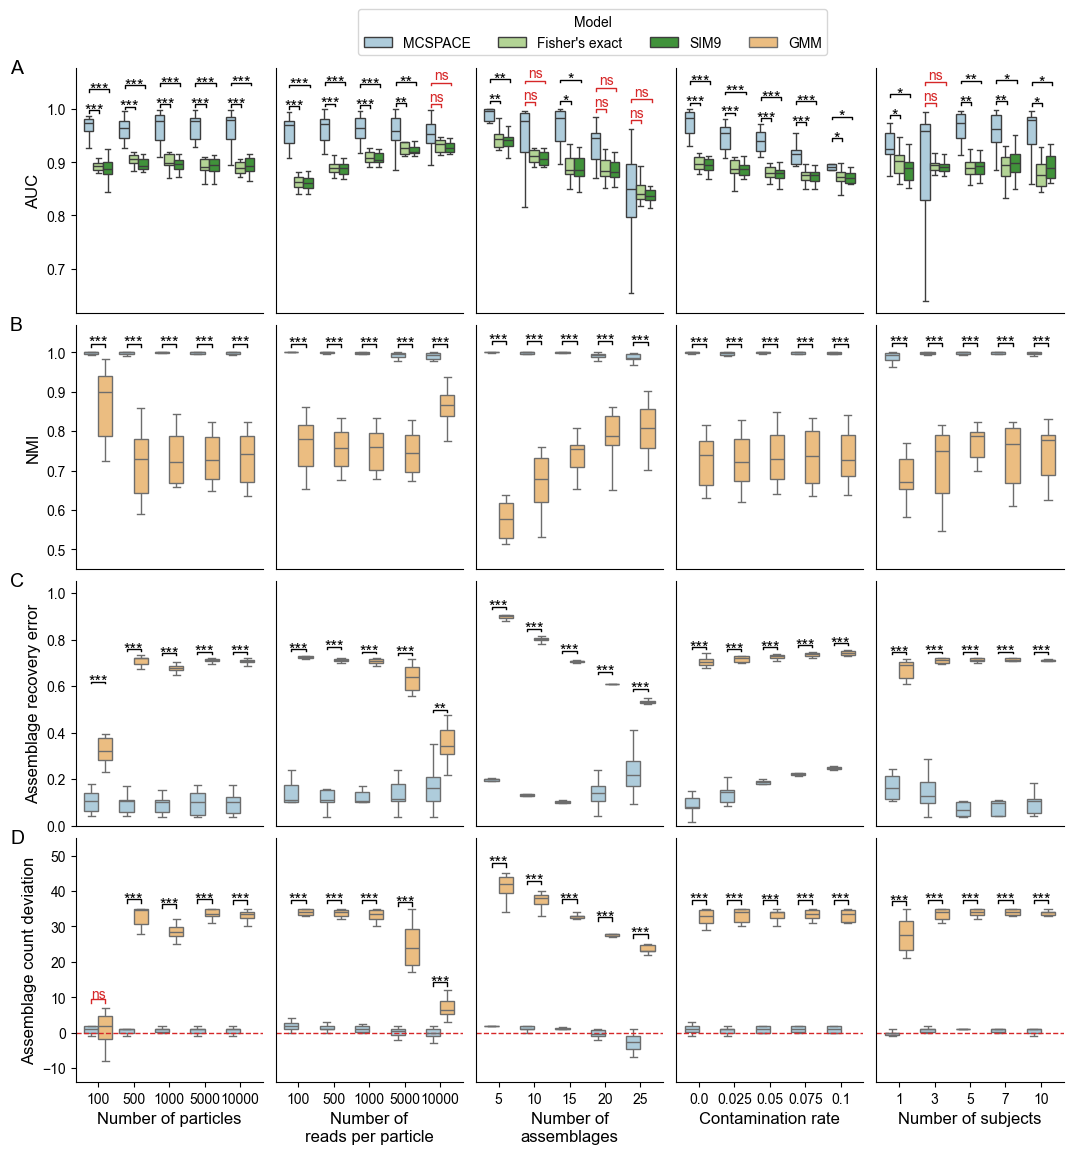

In [29]:
fontsize=12
label_fontsize=14
ticklabel_fontsize=10
rotation=0
grid = False

scale = 1.5
fig = plt.figure(figsize=(scale*8.5,scale*11))
gs = fig.add_gridspec(ncols=1,nrows=5, hspace=0.05)

wspace = 0.07
ncols = len(cases)
gspw, axpw = make_sub_gs_ax(fig,gs,0,0,ncols,wspace)
gsnmi, axnmi = make_sub_gs_ax(fig,gs,1,0,ncols,wspace)
gsnk, axnk = make_sub_gs_ax(fig,gs,3,0,ncols,wspace)
gsar, axar = make_sub_gs_ax(fig,gs,2,0,ncols,wspace)



# plot pairwise results ======================================
axpw = plot_results(axpw, pwres, cases, 'auc', pw_model_order, pw_palette, base_sample, 
                    width=1.0/7.0, offset=0.04, text_h=-0.007, h=0.005, ns_h_shift=-0.015, grid=grid)
axpw = share_axes(axpw,ncols)
for idx, ax in enumerate(axpw):
    ax.set_xlabel("")
    ax.set_xticklabels("") #ax.get_xticklabels(), fontsize=ticklabel_fontsize, rotation=rotation)

    ax.tick_params('x', length=0, width=0, which='major')
    if idx != 0:
        ax.tick_params('both', length=0, width=0, which='major')

    ax=box_to_ell_axes(ax)
axpw[0].set_ylabel("AUC", fontsize=fontsize)
axpw[0].set_yticklabels(axpw[0].get_yticklabels(), fontsize=ticklabel_fontsize)
axpw[0].text(label_x, label_y, 'A', horizontalalignment='left',verticalalignment='center', 
             transform=axpw[0].transAxes, fontsize=label_fontsize)

# plot NMI results ======================================
axnmi = plot_results(axnmi, arres, cases, 'NMI', ar_model_order, ar_palette, base_sample, text_h=-0.005,
                    grid=grid)
axnmi = share_axes(axnmi,ncols)
for idx, ax in enumerate(axnmi):
    ax.set_xlabel("")
    ax.set_xticklabels("") #ax.get_xticklabels(), fontsize=ticklabel_fontsize, rotation=rotation)
    
    ax.tick_params('x', length=0, width=0, which='major')
    if idx != 0:
        ax.tick_params('both', length=0, width=0, which='major')

    ax.set_ylim(0.45,1.07)
    ax=box_to_ell_axes(ax)

# axnmi[0].set_ylabel("Normalized\nmutual information", fontsize=fontsize)

axnmi[0].set_ylabel("NMI", fontsize=fontsize)
axnmi[0].set_yticklabels(axnmi[0].get_yticklabels(), fontsize=ticklabel_fontsize)
axnmi[0].text(label_x, label_y, 'B', horizontalalignment='left',verticalalignment='center', transform=axnmi[0].transAxes, fontsize=label_fontsize)

# plot comm err results ======================================
axar = plot_results(axar, arres, cases, 'community error', ar_model_order, ar_palette, base_sample, text_h=-0.02,
                   grid=grid)
for idx, ax in enumerate(axar):
    
    ax.set_xlabel("")
    ax.set_xticklabels("") #ax.get_xticklabels(), fontsize=ticklabel_fontsize, rotation=rotation)
    ax.set_ylim(0,1.05)
    ax.tick_params('x', length=0, width=0, which='major')
    if idx != 0:
        ax.tick_params('both', length=0, width=0, which='major')

    ax=box_to_ell_axes(ax)

axar = share_axes_r(axar,ncols)
axar[0].set_ylabel("Assemblage recovery error", fontsize=fontsize)
axar[0].set_yticklabels(axar[0].get_yticklabels(), fontsize=ticklabel_fontsize)
axar[0].text(label_x, label_y, 'C', horizontalalignment='left',verticalalignment='center', transform=axar[0].transAxes, fontsize=label_fontsize)

# plot nk err results ======================================
axnk = plot_results(axnk, arres, cases, 'nk_error', ar_model_order, ar_palette, base_sample, h=1.1, text_h=-0.5, 
                    ns_h_shift=-1.5, grid=grid)
axnk = share_axes(axnk,ncols)
axnk[0].set_xlabel("Number of particles", fontsize=fontsize)
axnk[1].set_xlabel("Number of\nreads per particle", fontsize=fontsize)
axnk[2].set_xlabel("Number of\nassemblages", fontsize=fontsize)
axnk[3].set_xlabel("Contamination rate", fontsize=fontsize)
axnk[4].set_xlabel("Number of subjects", fontsize=fontsize)
# axnk[0].set_ylabel("Number of inferred\nassemblages minus\ntrue number", fontsize=fontsize)
axnk[0].set_ylabel("Assemblage count deviation", fontsize=fontsize)
for idx,ax in enumerate(axnk):
    ax.axhline(y=0, color='tab:red', linestyle='--', linewidth=1)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=ticklabel_fontsize, rotation=rotation)
    ax.set_ylim(-14,55)
    ax=box_to_ell_axes(ax)
    if idx != 0:
        ax.tick_params('y', length=0, width=0, which='major')


axnk[0].set_yticklabels(axnk[0].get_yticklabels(), fontsize=ticklabel_fontsize)
axnk[0].text(label_x, label_y, 'D', horizontalalignment='left',verticalalignment='center', transform=axnk[0].transAxes, fontsize=label_fontsize)

# legend ===================================================
lines_labels = [axpw[0].get_legend_handles_labels(), axnmi[0].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
mod_sub = [0,1,2,4]
# mod_sub = [0,1,3]
lines = [lines[i] for i in mod_sub]
labels = [labels[i] for i in mod_sub]

labels = ['MCSPACE', "Fisher's exact", 'SIM9', 'GMM']
# labels = ['MCSPACE', "Fisher's exact", 'Basic GMM']
fig.legend(lines, labels, title='Model', loc='upper right', bbox_to_anchor=(0.72,0.92), ncol=4)

plt.savefig(outpath_mouse / f"figure_semisynthetic_{base_sample}.svg", bbox_inches="tight")